In [1]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
##### Transformation #####


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


Files already downloaded and verified
Files already downloaded and verified


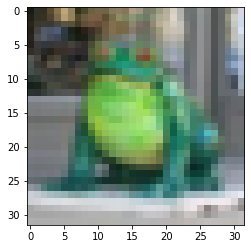

In [5]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

In [6]:
##### generate data ######

root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
    
def get_augpic(data, sample = 100, index = 0):
    '''
    Input : a list of picture, index of the pic we want, number of sample generate
    
    Output: list of pictures each have 2 random augmentations on it
    '''
    x = []
    original_pic = data[index][0]
    for i in range(sample):
        transform_pic = transform_train(original_pic)
        x.append(transform_pic)
    return x

def gen_data(B = 500, sample = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    
    return x_train, x_test (list) [[pic1_aug1, pic1_aug2, .....], [pic2_aug1, pic2_aug2, ...], ...]
    '''
    idx_train = np.random.randint(low = 0, high = len(train), size = B)
    idx__test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [get_augpic(data = train, sample = sample, index = idx_train[i]) for i in range(B)]
    X_test = [get_augpic(data = test, sample = sample, index = idx__test[i]) for i in range(B)]
    
    return X_train, X_test


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


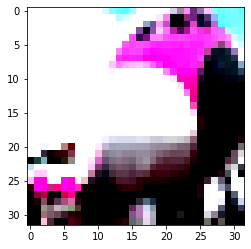

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


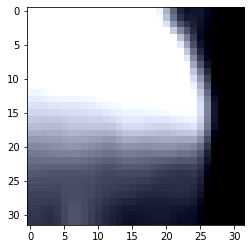

In [7]:
randomseed = 1
np.random.seed(randomseed) # random seed for pictures but not augmentation
X_train, X_test = gen_data(B=10, sample = 100)
#illustration
for i in range(2):
    imshow(X_train[0][i])

In [19]:
##### load checkpoint ! ######
def get_net(filename):
    '''
    Input: checkpoint filename
    Return: net, critic
     
    '''
    
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
    #load critics
    critics = LinearCritic(net.representation_dim, temperature=temperature).to(device)
    critics.load_state_dict(checkpoint['critic'])
    
    return net, critics

In [20]:
def get_h(x, net):
    '''
    Input x (list) , net, critics
    
    return h(list), for that list x
    '''
    h = []
    for i in range(len(x)):
        x_i = x[i].unsqueeze(0)
        h_i = net(x_i)
        h.append(h_i)
    return h

def get_hz(x, net, critics):
    '''
    Input x (list) , net, critics
    
    return h(list), z (list) for that list x
    '''
    #define g
    h = []
    z = []   
    model = critics
    model.eval()
    
    with torch.no_grad():
        for i in range(len(x)):
            x_i = x[i].unsqueeze(0)
            h_i = net(x_i)
            h.append(h_i)
            z_i = critics.project(h_i)
            z.append(z_i) 
    return h,z

def cal_trace(h):
    '''
    Input h(list)
    return covariance matrix of h
    
    '''
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    trace = np.trace(covMatrix)
    
    return trace

def cal_logdet(h):
    '''
    Input h(list)
    return log det covariance matrix of h
    
    '''
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    det = np.linalg.det(covMatrix + np.identity(covMatrix.shape[0])*0.1)
    if (det != 0):
        log_det = np.log(det)
    elif (det == 0):
        log_det = None
    
    return log_det

def mean_no_none(h):
    total_sum = 0
    number = 0
    for i in range(len(h)):
        if h[i] is None:
            total_sum = total_sum
            number = 0
        else:
            total_sum += h[i]
            number+= 1
    if number > 0:
        mean = total_sum/number
    else:
        mean = None
    return mean

def get_tr_cov_hz_giv_x(X, filename, mode = 'trace'):
    #load net and critics
    net, critics = get_net(filename)
    
    tr_H = []
    tr_Z = []
    
    for i in range(len(X)): #for each original picture
        x_i = X[i]
        h_i, z_i = get_hz(x_i, net, critics) #as a list
        
        #calculate covariance matrix
        if (mode == 'trace'):
            tr_h_i = cal_trace(h_i)      
            tr_z_i = cal_trace(z_i)
        elif (mode == 'log det'):
            tr_h_i = cal_logdet(h_i)
            tr_z_i = cal_logdet(z_i)
        
        tr_H.append(tr_h_i)
        tr_Z.append(tr_z_i)
      
    mean_tr_h = mean_no_none(tr_H)
    mean_tr_z = mean_no_none(tr_Z)
    return mean_tr_h, mean_tr_z
        
def gen_data1(B = 100):
    '''
    the main difference between this function and gen_data is that this function return
    a list [augpic1, augpic2, ...., augpic n] each original picture is selected once
    '''
    train, test = gen_data(B=B, sample = 1)
    X_train1 = [train[i][0] for i in range(len(train))]
    X_test1 = [test[i][0] for i in range(len(test))]
    return X_train1, X_test1

def gen_tr_cov_h(x, filename, mode = 'trace'):
    #load net and critics
    net, critics = get_net(filename)
    
    h,z = get_hz(x, net, critics)
    if (mode == 'trace'):
        tr_h = cal_trace(h)      
        tr_z = cal_trace(z)
    elif (mode == 'log det'):
        tr_h = cal_logdet(h)
        tr_z = cal_logdet(z)
    return tr_h, tr_z
    
    

In [21]:
def batch_get_hz(X, checkpointfile, mode = 'trace'):
    tr_h = {}
    tr_z = {}
    for cp in tqdm(checkpointfile):
        tr_h_cp, tr_z_cp = get_tr_cov_hz_giv_x(X, cp, mode = mode)
        tr_h[cp] = tr_h_cp
        tr_z[cp] = tr_z_cp
    return tr_h, tr_z

def batch_get_hz1(X, checkpointfile, mode = 'trace'):
    tr_h = {}
    tr_z = {}
    for cp in tqdm(checkpointfile):
        tr_h_cp, tr_z_cp = gen_tr_cov_h(X, cp, mode = mode)
        tr_h[cp] = tr_h_cp
        tr_z[cp] = tr_z_cp
    return tr_h, tr_z

In [22]:
# Plot helper
def my_plot(train_dict, test_dict, title = 'trace of covariance h|x', label1 = 'train', label2 = 'test'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'b')
    plt.plot([99+ 100*i for i in range(10)], [test_dict[cp] for cp in checkpointfile], label = label2, color = 'r')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
    
def my_plot2(list, title = 'best accuracy each checkpoint'):
    plt.plot([99+ 100*i for i in range(10)], [list[i] for i in range(10)], label = 'best_acc', color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# Now we calculate E_x( h|x) and E_x( z|x)

In [23]:
X_train, X_test = gen_data(B=10, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]

In [24]:
tr_covh_giv_x_train, tr_covz_giv_x_train= batch_get_hz(X_train, checkpointfile)

100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


In [25]:
tr_covh_giv_x_test, tr_covz_giv_x_test= batch_get_hz(X_test, checkpointfile)

100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


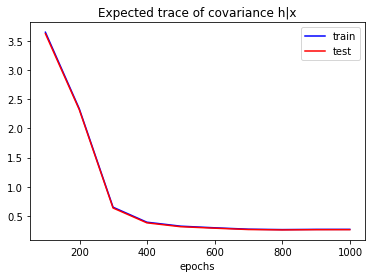

In [26]:
my_plot(tr_covh_giv_x_train, tr_covh_giv_x_test, title = 'Expected trace of covariance h|x')

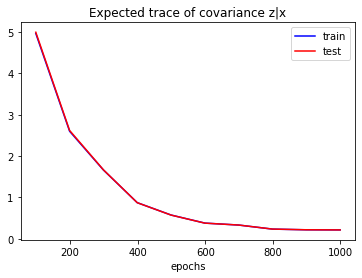

In [27]:
my_plot(tr_covz_giv_x_train, tr_covz_giv_x_test, title = 'Expected trace of covariance z|x')

# log det cov

In [28]:
logdet_covh_giv_x_train, logdet_covz_giv_x_train= batch_get_hz(X_train, checkpointfile, mode = 'log det')

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


In [29]:
logdet_covz_giv_x_train

{'resnet18_new.pth99': -225.7838119886945,
 'resnet18_new.pth199': -226.65422716785966,
 'resnet18_new.pth299': -227.31384028744742,
 'resnet18_new.pth399': -227.96245853649754,
 'resnet18_new.pth499': -228.3348659562064,
 'resnet18_new.pth599': -228.67655007864687,
 'resnet18_new.pth699': -228.77967789321096,
 'resnet18_new.pth799': -229.03772199815285,
 'resnet18_new.pth899': -229.08777900765685,
 'resnet18_new.pth999': -229.09727012577363}

In [30]:
logdet_covh_giv_x_test, logdet_covz_giv_x_test= batch_get_hz(X_test, checkpointfile, mode = 'log det')

100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


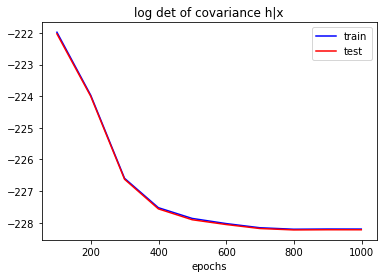

In [31]:
my_plot(logdet_covh_giv_x_train, logdet_covh_giv_x_test, title = 'log det of covariance h|x')

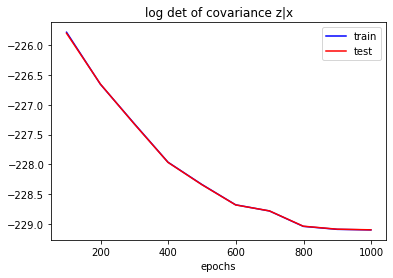

In [32]:
my_plot(logdet_covz_giv_x_train, logdet_covz_giv_x_test, title = 'log det of covariance z|x')
#everything is none -_-

In [36]:
X_train1, X_test1 = gen_data1(B=2000)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
tr_covh_train, tr_covz_train= batch_get_hz1(X_train1, checkpointfile, mode ='trace')
tr_covh_test, tr_covz_test= batch_get_hz1(X_test1, checkpointfile, mode ='trace')

100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


In [37]:
logdet_covh_train, logdet_covz_train= batch_get_hz1(X_train1, checkpointfile, mode ='log det')
logdet_covh_test, logdet_covz_test= batch_get_hz1(X_test1, checkpointfile, mode ='log det')

100%|██████████| 10/10 [01:29<00:00,  8.94s/it]


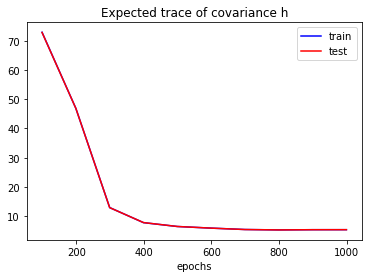

In [38]:
my_plot(tr_covh_train, tr_covh_test, title = 'Expected trace of covariance h')

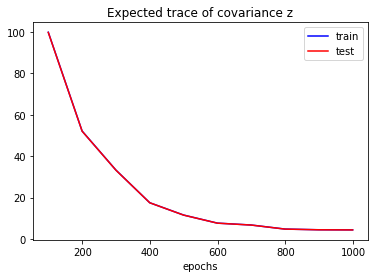

In [39]:
my_plot(tr_covz_train, tr_covz_test, title = 'Expected trace of covariance z')

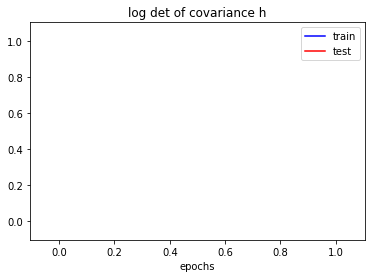

In [42]:
my_plot(logdet_covh_train, logdet_covh_test, title = 'log det of covariance h')

In [53]:
logdet_covh_train

{'resnet18_new.pth99': None,
 'resnet18_new.pth199': None,
 'resnet18_new.pth299': None,
 'resnet18_new.pth399': None,
 'resnet18_new.pth499': None,
 'resnet18_new.pth599': None,
 'resnet18_new.pth699': None,
 'resnet18_new.pth799': None,
 'resnet18_new.pth899': None,
 'resnet18_new.pth999': None}

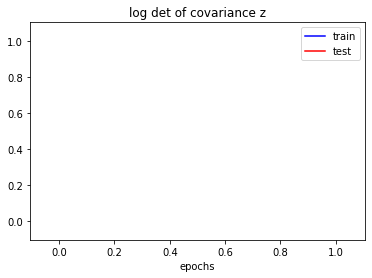

In [44]:
my_plot(logdet_covz_train, logdet_covz_test, title = 'log det of covariance z')

# Compare h|x with h

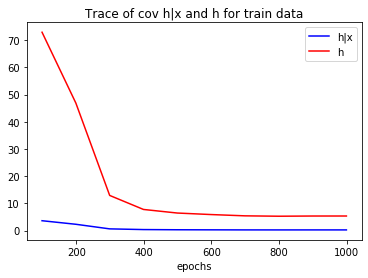

In [45]:
my_plot(tr_covh_giv_x_train, tr_covh_train, title = 'Trace of cov h|x and h for train data', label1 = 'h|x', label2 ='h')

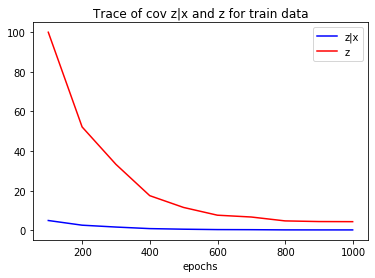

In [46]:
my_plot(tr_covz_giv_x_train, tr_covz_train, title = 'Trace of cov z|x and z for train data', label1 = 'z|x', label2 ='z')

# Visualise with performance of the encoder (lbfgs.py)

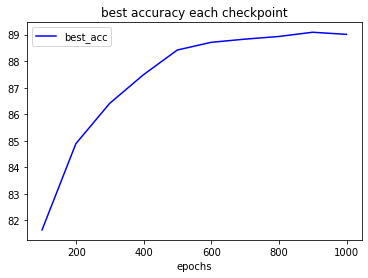

In [47]:
#the number here came from running batch_lbfgs_linear_clf.py
best_acc = [81.64, 84.89,86.41,87.49,88.42,88.71,88.83,88.93,89.09,89.01]
my_plot2(best_acc)

In [48]:
def plot_scatter(x,y, xlabel = 'best_acc', ylabel ='cov trace h|x'):
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

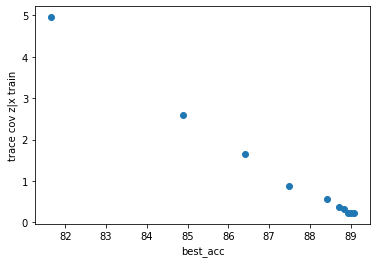

In [49]:
plot_scatter(best_acc, [tr_covz_giv_x_train[cp] for cp in checkpointfile], ylabel = 'trace cov z|x train')

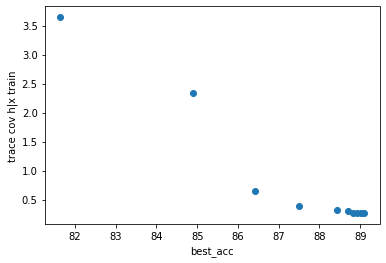

In [50]:
plot_scatter(best_acc, [tr_covh_giv_x_train[cp] for cp in checkpointfile], ylabel = 'trace cov h|x train')

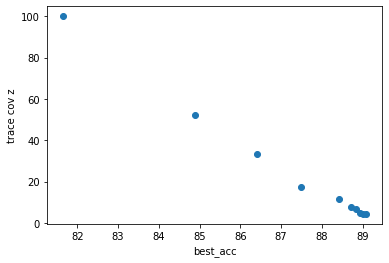

In [51]:
plot_scatter(best_acc, [tr_covz_train[cp] for cp in checkpointfile], ylabel = 'trace cov z')

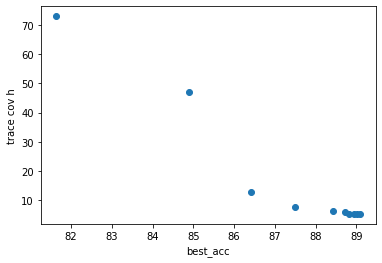

In [52]:
plot_scatter(best_acc, [tr_covh_train[cp] for cp in checkpointfile], ylabel = 'trace cov h')